In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Discard the output of this cell.
%%capture
# Install the required libraries.
!pip install pafy youtube-dl moviepy

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed (seed_constant)

In [ ]:
# Discard the output of this cell.
%%capture
# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#Extract the Dataset
!unrar x UCF50.rar

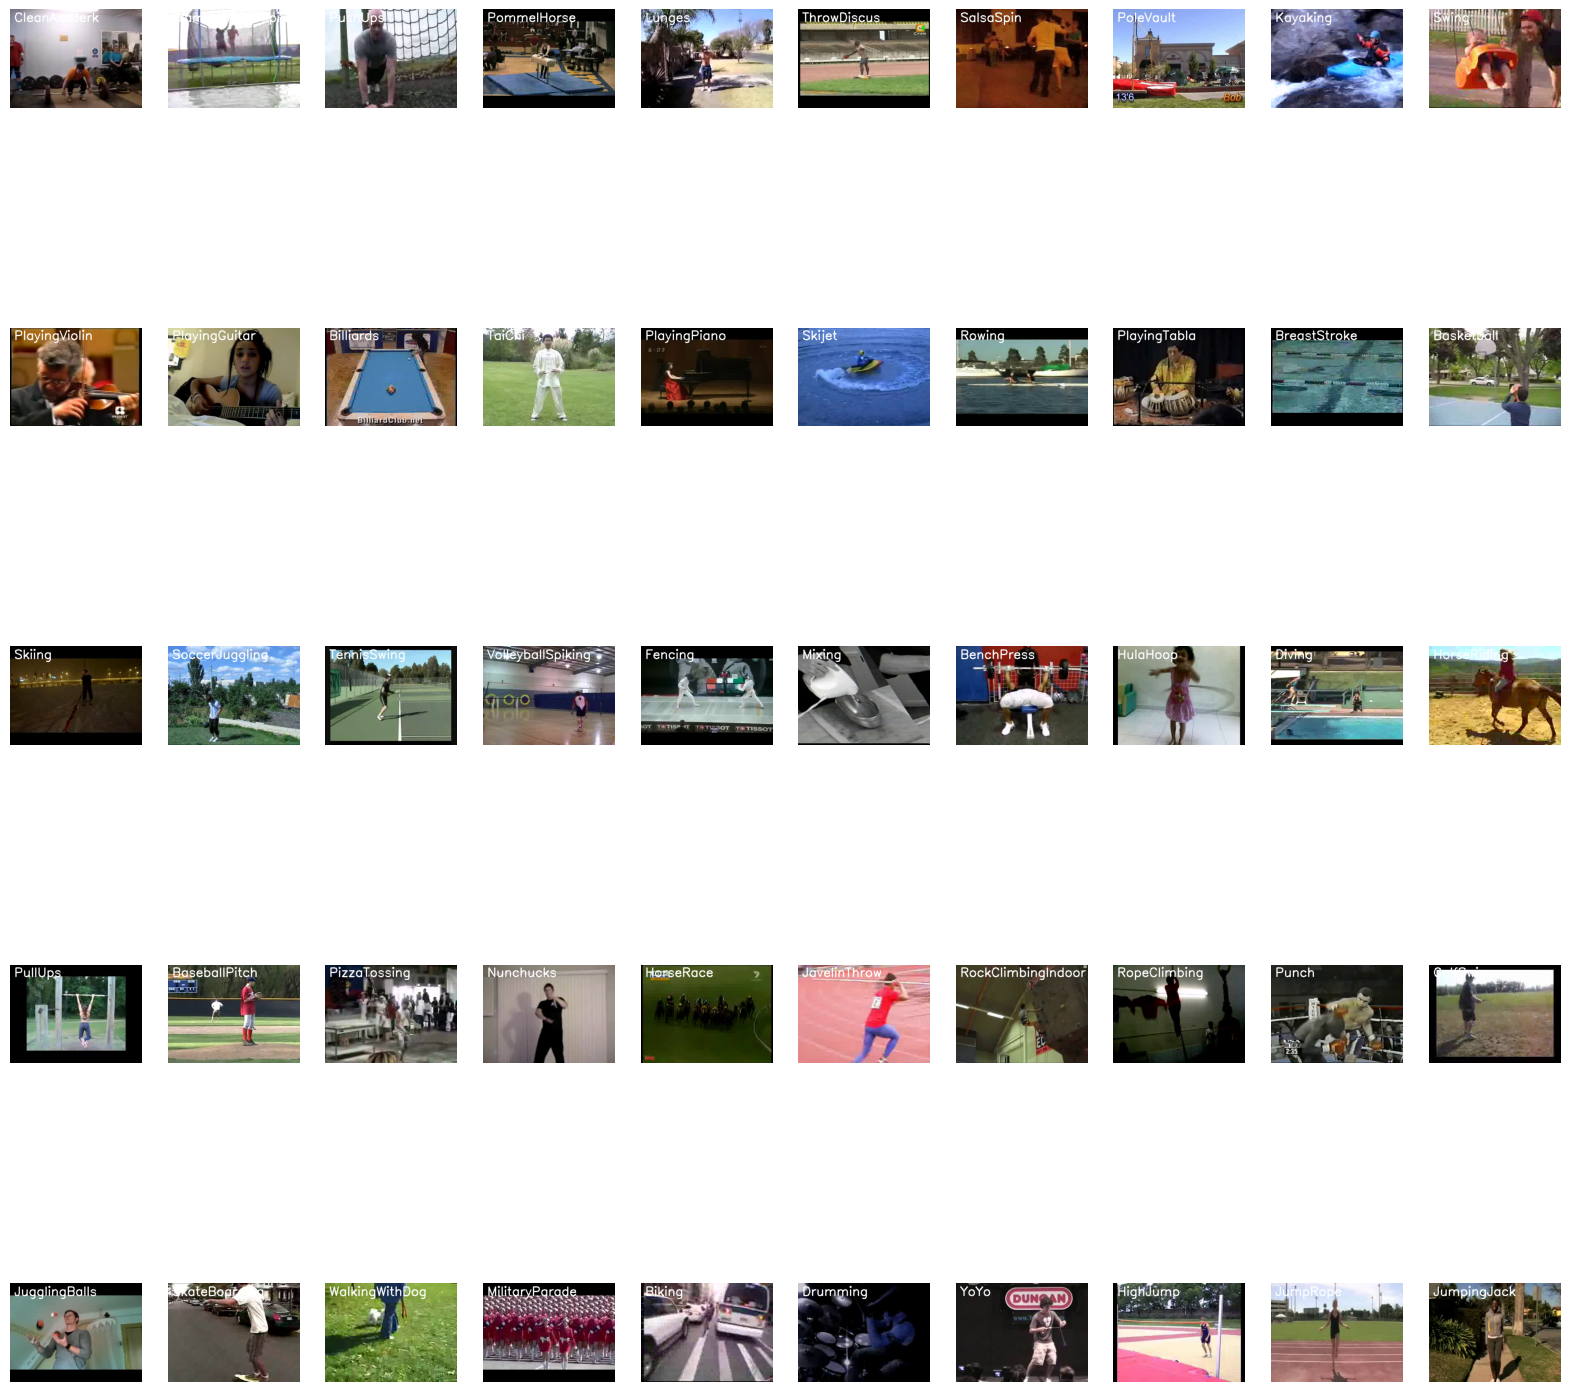

In [ ]:
import random

plt.figure(figsize=(20, 20))
all_classes_names = os.listdir('UCF50')

for counter, selected_class_Name in enumerate(all_classes_names, 1):
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Check if there are video files in the folder
    if video_files_names_list:
        selected_video_file_name = random.choice(video_files_names_list)
        video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
        _, bgr_frame = video_reader.read()
        video_reader.release()
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        plt.subplot(5, 10, counter)  # Adjust the number of rows and columns as needed
        plt.imshow(rgb_frame)
        plt.axis('off')
    else:
        print(f"No video files found in folder {selected_class_Name}")

plt.show()

In [ ]:
IMAGE_HEIGHT,IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 20
DATASET_DIR="UCF50"
CLASSES_LIST=["PommelHorse","PushUps","HorseRace","HorseRiding"]

In [ ]:
def frames_extraction(video_path):
  frames_list=[]
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame = video_reader.read()
    if not success:
      break

    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)
  video_reader.release()

  return frames_list

In [ ]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []
  for class_index,class_name in enumerate(CLASSES_LIST[:40]):
    print(f'Extracting Data of CLass: {class_name}')

    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)

  return features,labels,video_files_paths

In [ ]:
features,labels,video_files_paths = create_dataset()

Extracting Data of CLass: PommelHorse
Extracting Data of CLass: PushUps
Extracting Data of CLass: HorseRace
Extracting Data of CLass: HorseRiding


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train,features_test,labels_train,lables_test = train_test_split(features,one_hot_encoded_labels,
                                                                         test_size = 0.25,shuffle = True,
                                                                         random_state = seed_constant)

In [ ]:
def create_LRCN_model():


    model = Sequential()

    #Model Architecture.
    #---------------------------------------------------------------------------------------------------------------------------------------------------#

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    #K-LAYERED LSTM K=1
    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST[:10]), activation = 'softmax'))

    #------------------------------------------------------------------------------------------------------------------------------------------------#

    model.summary()


    return model


In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

In [ ]:
import time

# before training
start_time = time.time()

early_stopping_callback = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True)

LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training
LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4,
                                             shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
83/83 [==============================] - 27s 289ms/step - loss: 1.2828 - accuracy: 0.3897 - val_loss: 1.2114 - val_accuracy: 0.3976
Epoch 2/50
83/83 [==============================] - 16s 188ms/step - loss: 1.0671 - accuracy: 0.5710 - val_loss: 0.9998 - val_accuracy: 0.6506
Epoch 3/50
83/83 [==============================] - 21s 254ms/step - loss: 0.8818 - accuracy: 0.6677 - val_loss: 0.9261 - val_accuracy: 0.6024
Epoch 4/50
83/83 [==============================] - 16s 188ms/step - loss: 0.8052 - accuracy: 0.6888 - val_loss: 0.7992 - val_accuracy: 0.6867
Epoch 5/50
83/83 [==============================] - 17s 205ms/step - loss: 0.7051 - accuracy: 0.7372 - val_loss: 0.7374 - val_accuracy: 0.6747
Epoch 6/50
83/83 [==============================] - 17s 199ms/step - loss: 0.6588 - accuracy: 0.7311 - val_loss: 0.9121 - val_accuracy: 0.6265
Epoch 7/50
83/83 [==============================] - 15s 187ms/step - loss: 0.5826 - accuracy: 0.7644 - val_loss: 0.6356 - val_accuracy: 0.7711

In [ ]:
# end time after training
end_time = time.time()

# total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Total training time: 895.98 seconds


In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test,lables_test)

5/5 [==============================] - 3s 571ms/step - loss: 0.3659 - accuracy: 0.9281


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y-%m-%d %H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model_____Date_Time_{current_date_time_string} _Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'
# Save the Model.
LRCN_model.save(model_file_name)

  saving_api.save_model(



In [ ]:
import os
from moviepy.editor import VideoFileClip
test_videos_directory='test_videos'
os.makedirs(test_videos_directory,exist_ok=True)


input_video_file_path = '/content/drive/MyDrive/Cognitica/Test_dir/Action.mp4'

video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]

print(f"Video Name: {video_title}")

Video Name: Action


In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                  video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break  # Exit the loop when there are no more frames

        # Check if the frame is empty before resizing
        if not frame.size:
            continue

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
%%capture


output_dir = "/content/drive/MyDrive/Cognitica/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)


processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))
processed_video.ipython_display()

In [ ]:
%%capture

true_labels = []  # true labels for each frame
predicted_labels = []  # predicted labels for each frame
#predict labels for a video
def predict_on_video(video_file_path, true_label):
    video_reader = cv2.VideoCapture(video_file_path)
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break


        if not frame.size:
            continue

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]


            true_labels.append(true_label)
            predicted_labels.append(predicted_class_name)

    video_reader.release()

    return true_labels, predicted_labels

#test vids
class_name_mapping = {
    'v_Diving_g25_c02': 'Diving',
    'v_Drumming_g25_c07': 'Drumming',
    'v_HighJump_g25_c04': 'HighJump',
    'v_HorseRace_g25_c04': 'HorseRace',
    'v_HorseRiding_g25_c21': 'HorseRiding',
    'v_JumpingJack_g25_c07': 'JumpingJack',
    'v_PlayingTabla_g22_c04': 'PlayingTabla',
    'v_PoleVault_g17_c09': 'PoleVault',
    'v_PommelHorse_g05_c04': 'PommelHorse',
    'v_PushUps_g26_c04': 'PushUps',
}

all_true_labels = []
all_predicted_labels = []


test_videos_directory = '/content/drive/MyDrive/Cognitica/Test_dir'

for video_file in os.listdir(test_videos_directory):
    if video_file.endswith(".avi"):
        video_file_path = os.path.join(test_videos_directory, video_file)
        video_title = os.path.splitext(os.path.basename(video_file_path))[0]

        # Map video_title
        class_name = class_name_mapping.get(video_title, 'Unknown')


        true_labels_video, predicted_labels_video = predict_on_video(video_file_path, true_label=class_name)

        all_true_labels.extend(true_labels_video)
        all_predicted_labels.extend(predicted_labels_video)

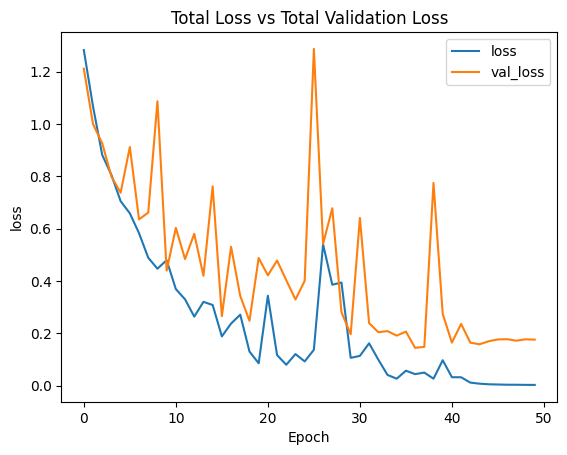

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, train_metric, val_metric, title):
    plt.plot(history.history[train_metric], label=train_metric)
    plt.plot(history.history[val_metric], label=val_metric)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(train_metric)
    plt.legend()
    plt.show()

# Example usage:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


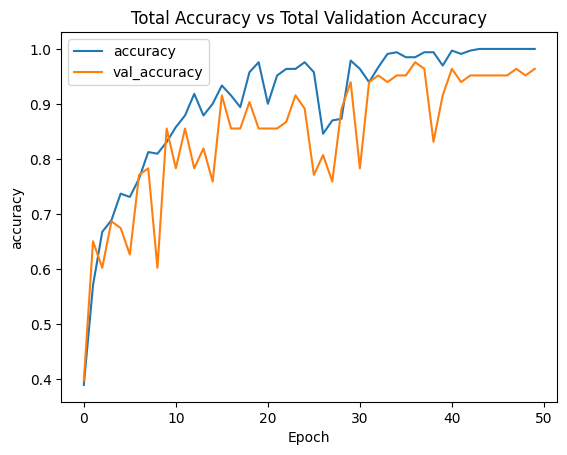

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric (LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

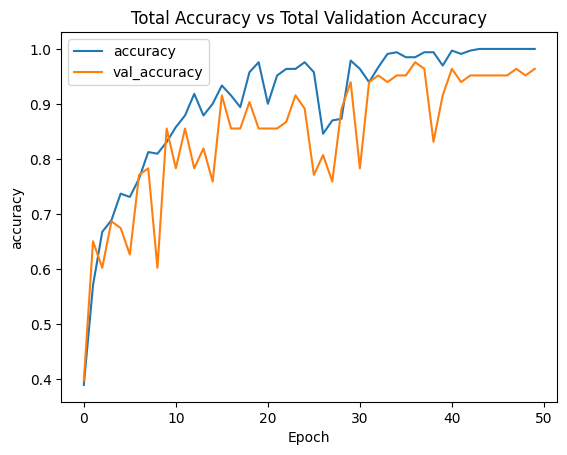

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric (LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')